In [1]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Dropout
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import ipywidgets as widgets

In [2]:
# import the floor plan image dataset
filelist = glob.glob('SquidOutput/Latest/Doors/*.png')
x_images = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist])

In [3]:
# image preprocessing 
x_images = x_images.astype(np.float32)
x_images = x_images / 255
x_images = x_images.reshape(-1, 40,40, 1)

In [4]:
len(x_images)

1000

In [5]:
# create a sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
#build the encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(40, 40, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
drop = Dropout(0.2, seed=1)(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(drop)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 20, 20, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 64)   18496       dropout[0][0]                    
____________________________________________________________________________________________

In [7]:
#build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(10 * 10 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((10, 10, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
drop = Dropout(0.2, seed=1)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(drop)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6400)              19200     
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 20, 20, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 40, 40, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 40, 40, 1)         289 

In [8]:
#define the VAE as a Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 40 * 40
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [9]:
#train the VAE...
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_images, epochs=60, batch_size=100)
vae.save_weights('weights6.h5')

Epoch 1/60
10/10 [==============================] - 1s 78ms/step - loss: 967.0466 - reconstruction_loss: 931.6107 - kl_loss: 35.4359
Epoch 2/60
10/10 [==============================] - 1s 77ms/step - loss: 602.4472 - reconstruction_loss: 578.8175 - kl_loss: 23.6297
Epoch 3/60
10/10 [==============================] - 1s 76ms/step - loss: 488.2127 - reconstruction_loss: 486.0080 - kl_loss: 2.2047
Epoch 4/60
10/10 [==============================] - 1s 75ms/step - loss: 451.1582 - reconstruction_loss: 449.4037 - kl_loss: 1.7545
Epoch 5/60
10/10 [==============================] - 1s 76ms/step - loss: 436.6527 - reconstruction_loss: 434.6427 - kl_loss: 2.0100
Epoch 6/60
10/10 [==============================] - 1s 74ms/step - loss: 430.1756 - reconstruction_loss: 427.8870 - kl_loss: 2.2886
Epoch 7/60
10/10 [==============================] - 1s 77ms/step - loss: 425.2039 - reconstruction_loss: 422.6722 - kl_loss: 2.5317
Epoch 8/60
10/10 [==============================] - 1s 78ms/step - loss: 4

In [9]:
#...or load the weights of a previously trained model
vae2 = VAE(encoder, decoder)
vae2.compile(optimizer=keras.optimizers.Adam())
vae2.load_weights('weights5.h5')

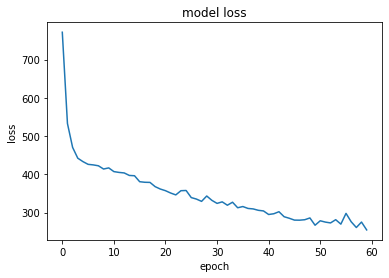

In [18]:
#visualise loss graph
%matplotlib inline

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig(fname='loss_ep60_b100', dpi=300)
plt.show()

Test Images


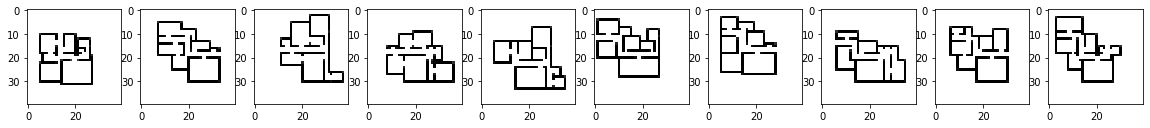

Reconstruction of Test Images


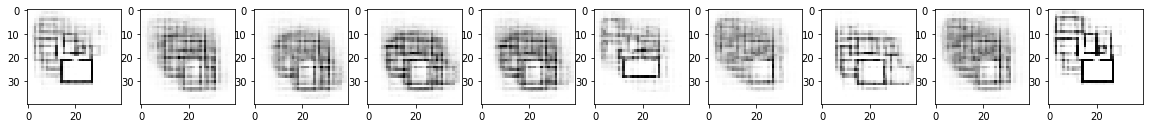

In [11]:
#display images before and after autoencoding
x_encoded = encoder.predict(x_images)
pred_test = decoder.predict(x_encoded)
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_images[i, ..., 0], cmap='gray')
plt.savefig(fname='before', dpi=300)
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred_test[i, ..., 0], cmap='gray')  
plt.savefig(fname='after', dpi=300)
plt.show()

In [10]:
# load and preprocess existing building floor plan images
jnfilelist = glob.glob('SquidOutput/Latest/Existing/Doors/JeanNouvel/*.png')
plans_jn = np.array([np.array(Image.open(fname).convert('L')) for fname in jnfilelist])
barbfilelist = glob.glob('SquidOutput/Latest/Existing/Doors/Barbican/*.png')
plans_barb = np.array([np.array(Image.open(fname).convert('L')) for fname in barbfilelist])
hdmfilelist = glob.glob('SquidOutput/Latest/Existing/Doors/HerzogDeMeuron/*.png')
plans_hdm = np.array([np.array(Image.open(fname).convert('L')) for fname in hdmfilelist])

In [11]:
data_jn = plans_jn.astype(np.float32)
data_jn = data_jn / 255
data_jn = data_jn.reshape(-1, 40,40, 1)
data_barb = plans_barb.astype(np.float32)
data_barb = data_barb / 255
data_barb = data_barb.reshape(-1, 40,40, 1)
data_hdm = plans_hdm.astype(np.float32)
data_hdm = data_hdm / 255
data_hdm = data_hdm.reshape(-1, 40,40, 1)

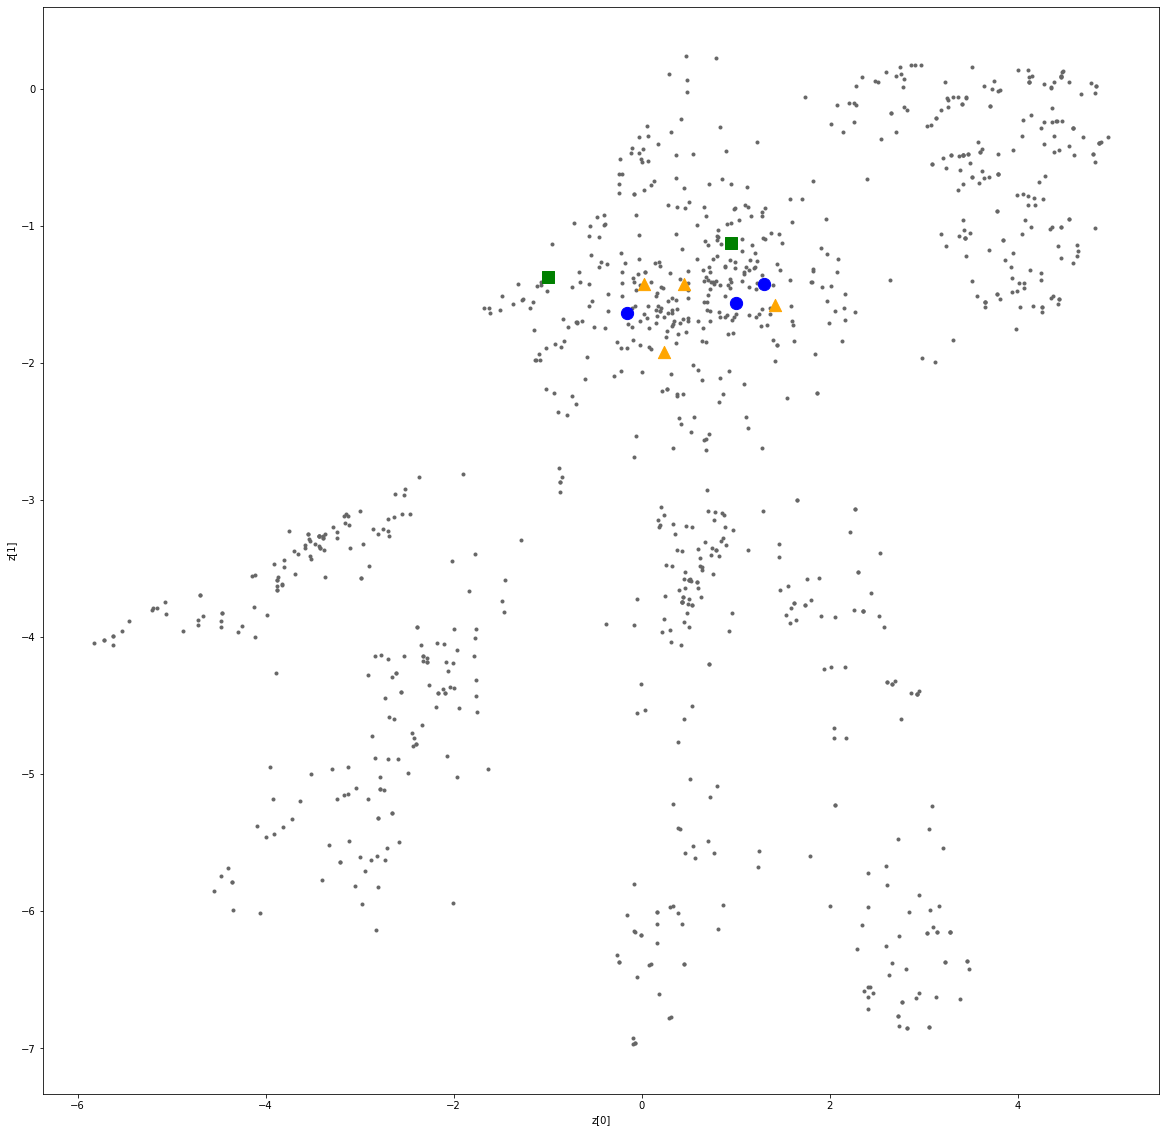

In [41]:
#visualise the latent space
%matplotlib inline
    
z_mean, _, _ = encoder.predict(x_images)
z_mean_jn, _, _ = encoder.predict(data_jn)
z_mean_barb, _, _ = encoder.predict(data_barb)
z_mean_hdm, _, _ = encoder.predict(data_hdm)
fig = plt.figure(figsize=(20, 20))
x = z_mean[:, 0]
y = z_mean[:, 1]
plt.scatter(x, y, marker='.', color='0.4')
plt.scatter(z_mean_jn[:, 0], z_mean_jn[:, 1], marker='^', color='orange', s=150)
plt.scatter(z_mean_barb[:, 0], z_mean_barb[:, 1], marker='s', color='green', s=150)
plt.scatter(z_mean_hdm[:, 0], z_mean_hdm[:, 1], marker='o', color='blue', s=150)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig(fname='final_plot2', dpi=300)
plt.show()

In [13]:
colfilelist = glob.glob('SquidOutput/Latest/Colours/*.png')
colours = np.array([np.array(Image.open(fname)) for fname in colfilelist])

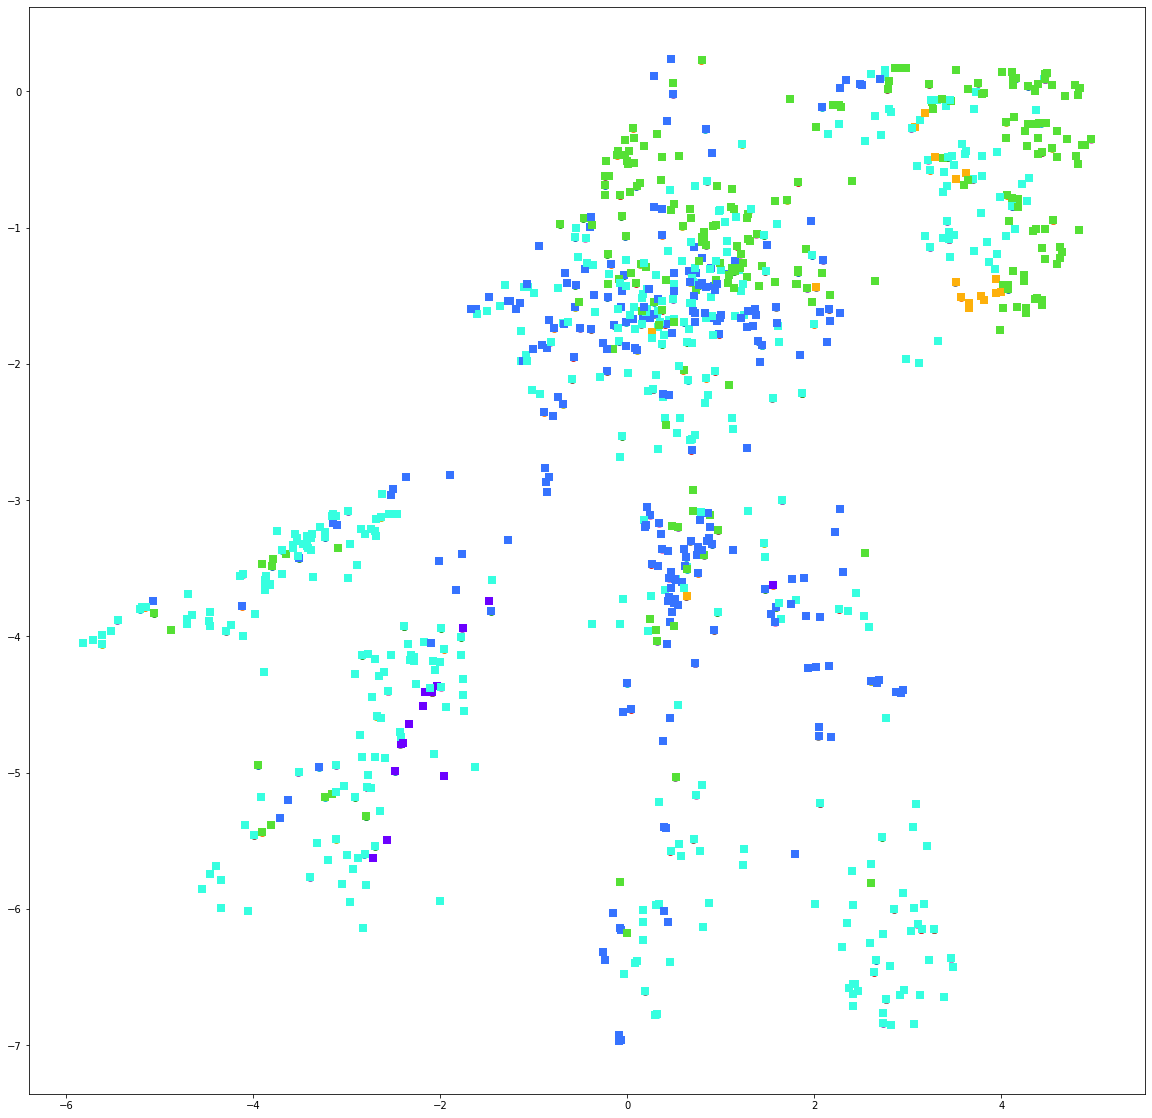

In [33]:
# visualise the latent space with total mean depth markers
%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 20)
z_mean, _, _ = encoder.predict(x_images)
a = z_mean[:, 0]
b = z_mean[:, 1]

def main():
    
    fig, ax = plt.subplots()

    for x, y, image_path in zip(a, b, colours):
        imscatter(x, y, image_path, zoom=1.5, ax=ax)
        ax.scatter(x, y)
        

    
    
plt.show()

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:

        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

main()
#plt.savefig('Total_mean_depth3.png', dpi=300)

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


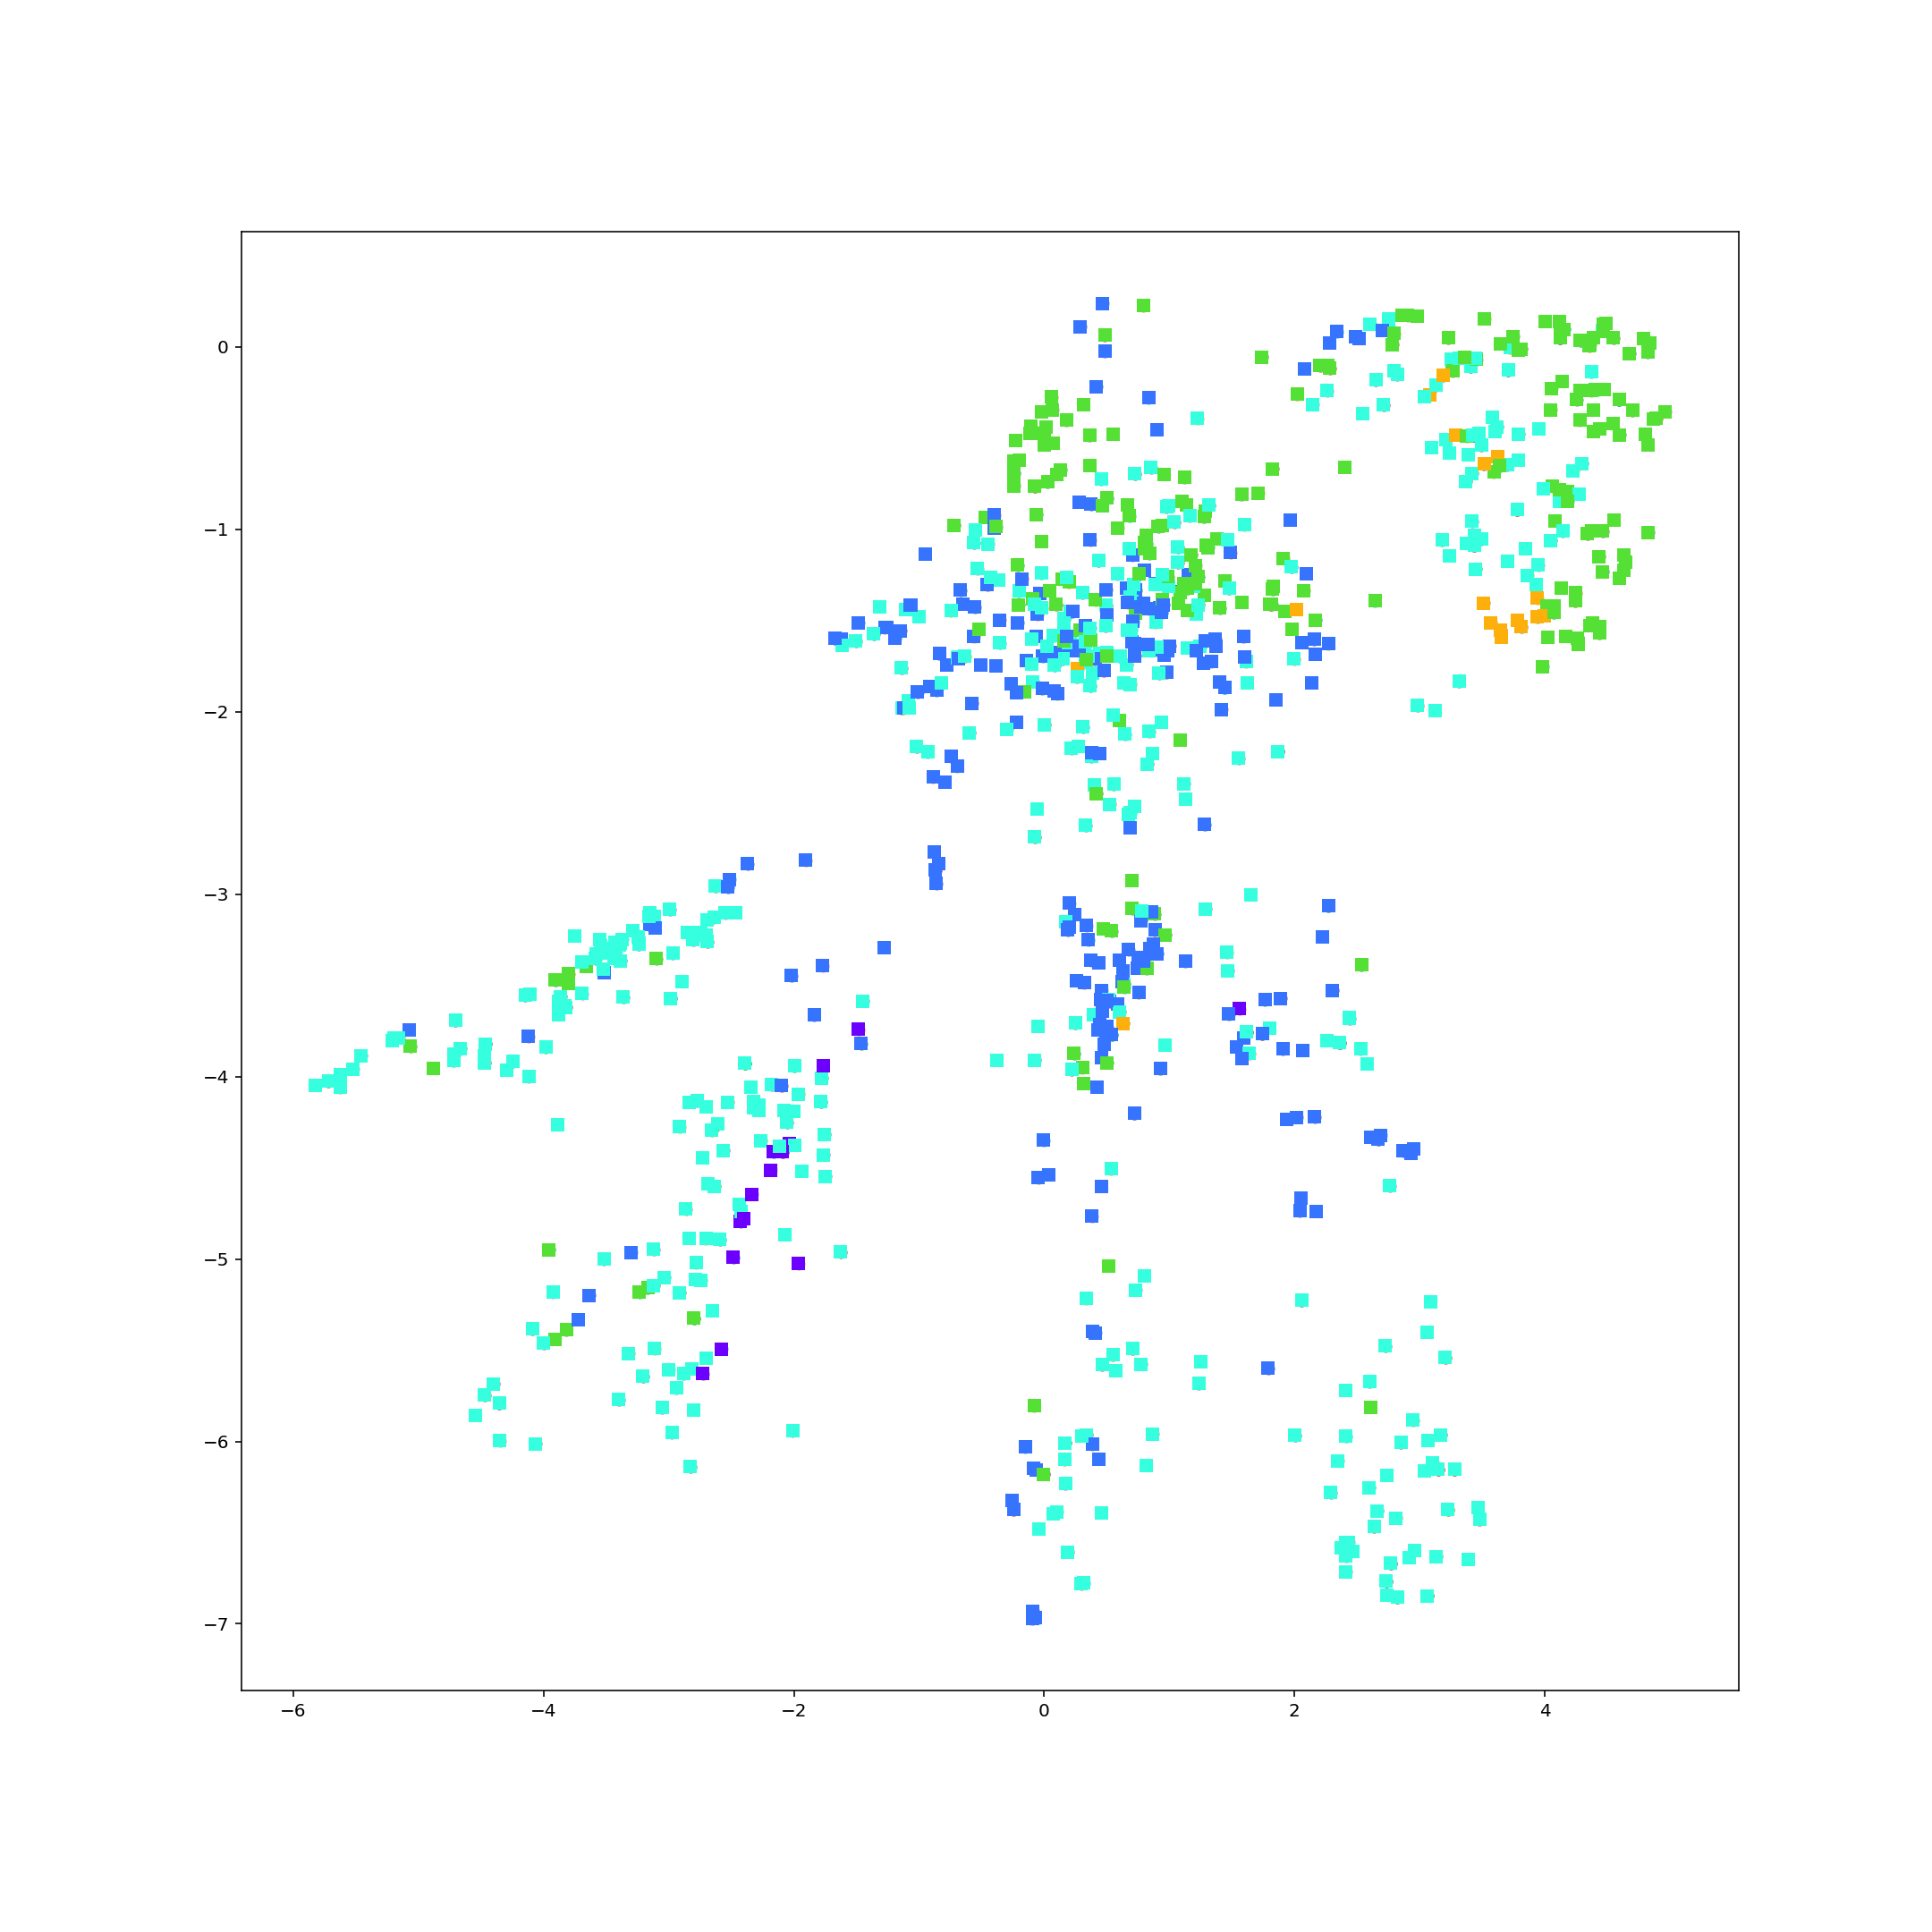

HTML(value='')

In [36]:
%pylab notebook
plt.rcParams['figure.figsize'] = (15, 15)

main()

w = widgets.HTML()
display(w)

In [21]:
# images that are going to be used as markers on the visualisation
plans = np.array([np.array(Image.open(fname)) for fname in filelist])
plans_jn = np.array([np.array(Image.open(fname)) for fname in jnfilelist])
plans_barb = np.array([np.array(Image.open(fname)) for fname in barbfilelist])
plans_hdm = np.array([np.array(Image.open(fname)) for fname in hdmfilelist])

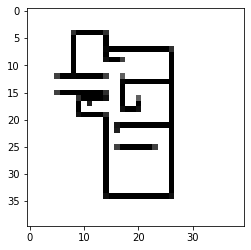

In [14]:
plt.imshow(plans_jn[3])

In [22]:
# put them together
plans_all = np.concatenate([plans, plans_jn, plans_barb, plans_hdm], axis=0)

In [23]:
# put the preprocessed images together as well
data_all = np.concatenate([x_images, data_jn, data_barb, data_hdm], axis=0)

In [24]:
# load images with mean depth colouring
mdfilelist = glob.glob('SquidOutput/Latest/MeanDepth/*.png')
mdplans = np.array([np.array(Image.open(fname)) for fname in mdfilelist])

In [25]:
mdjnfilelist = glob.glob('SquidOutput/Latest/Existing/MeanDepth/JeanNouvel/*.png')
mdjn = np.array([np.array(Image.open(fname)) for fname in mdjnfilelist])
mdbarbfilelist = glob.glob('SquidOutput/Latest/Existing/MeanDepth/Barbican/*.png')
mdbarb = np.array([np.array(Image.open(fname)) for fname in mdbarbfilelist])
mdhdmfilelist = glob.glob('SquidOutput/Latest/Existing/MeanDepth/HerzogDeMeuron/*.png')
mdhdm = np.array([np.array(Image.open(fname)) for fname in mdhdmfilelist])

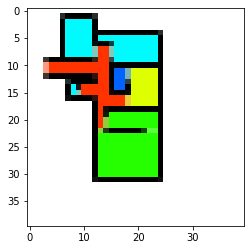

In [19]:
plt.imshow(mdjn[3])

In [26]:
# put mean depth images together
md_all = np.concatenate([mdplans, mdjn, mdbarb, mdhdm], axis=0)

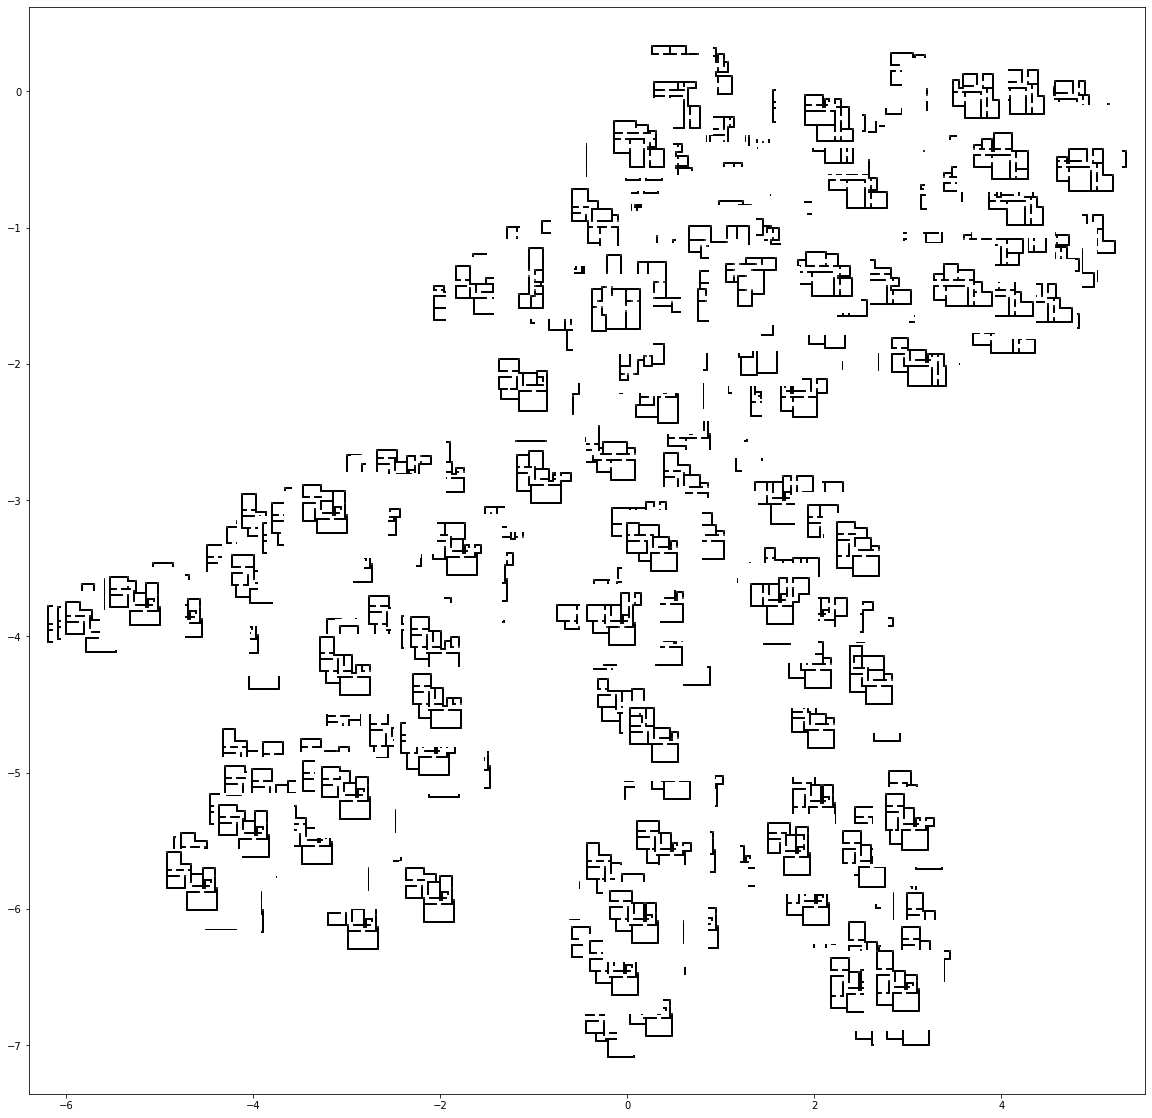

In [39]:
# visualise the latent space with floor plan images as markers
%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 20)
z_mean, _, _ = encoder.predict(data_all)
a = z_mean[:, 0]
b = z_mean[:, 1]

def main():
    
    fig, ax = plt.subplots()

    for x, y, image_path in zip(a, b, plans_all):
        imscatter(x, y, image_path, zoom=2, ax=ax)
        ax.scatter(x, y)
        

    
    
plt.show()

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:

        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

main()
#plt.savefig('Plot1_29.png', dpi=300)

In [25]:
data2 = np.concatenate([data_jn, data_barb, data_hdm], axis=0)
plans2 = np.concatenate([plans_jn, plans_barb, plans_hdm], axis=0)
md2 = np.concatenate([mdjn, mdbarb, mdhdm], axis=0)

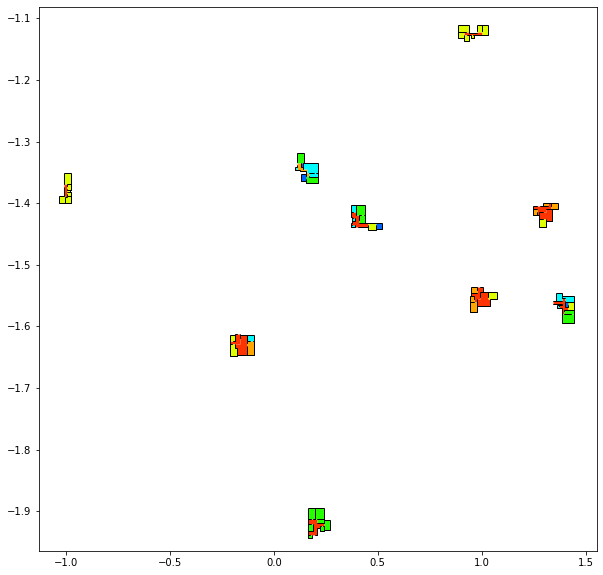

In [27]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
z_mean, _, _ = encoder.predict(data2)
a = z_mean[:, 0]
b = z_mean[:, 1]

def main():
    
    fig, ax = plt.subplots()

    for x, y, image_path in zip(a, b, md2):
        imscatter(x, y, image_path, zoom=1, ax=ax)
        ax.scatter(x, y)
        

    
    
plt.show()

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:

        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

main()
#plt.savefig('Plot1_29.png', dpi=300)

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


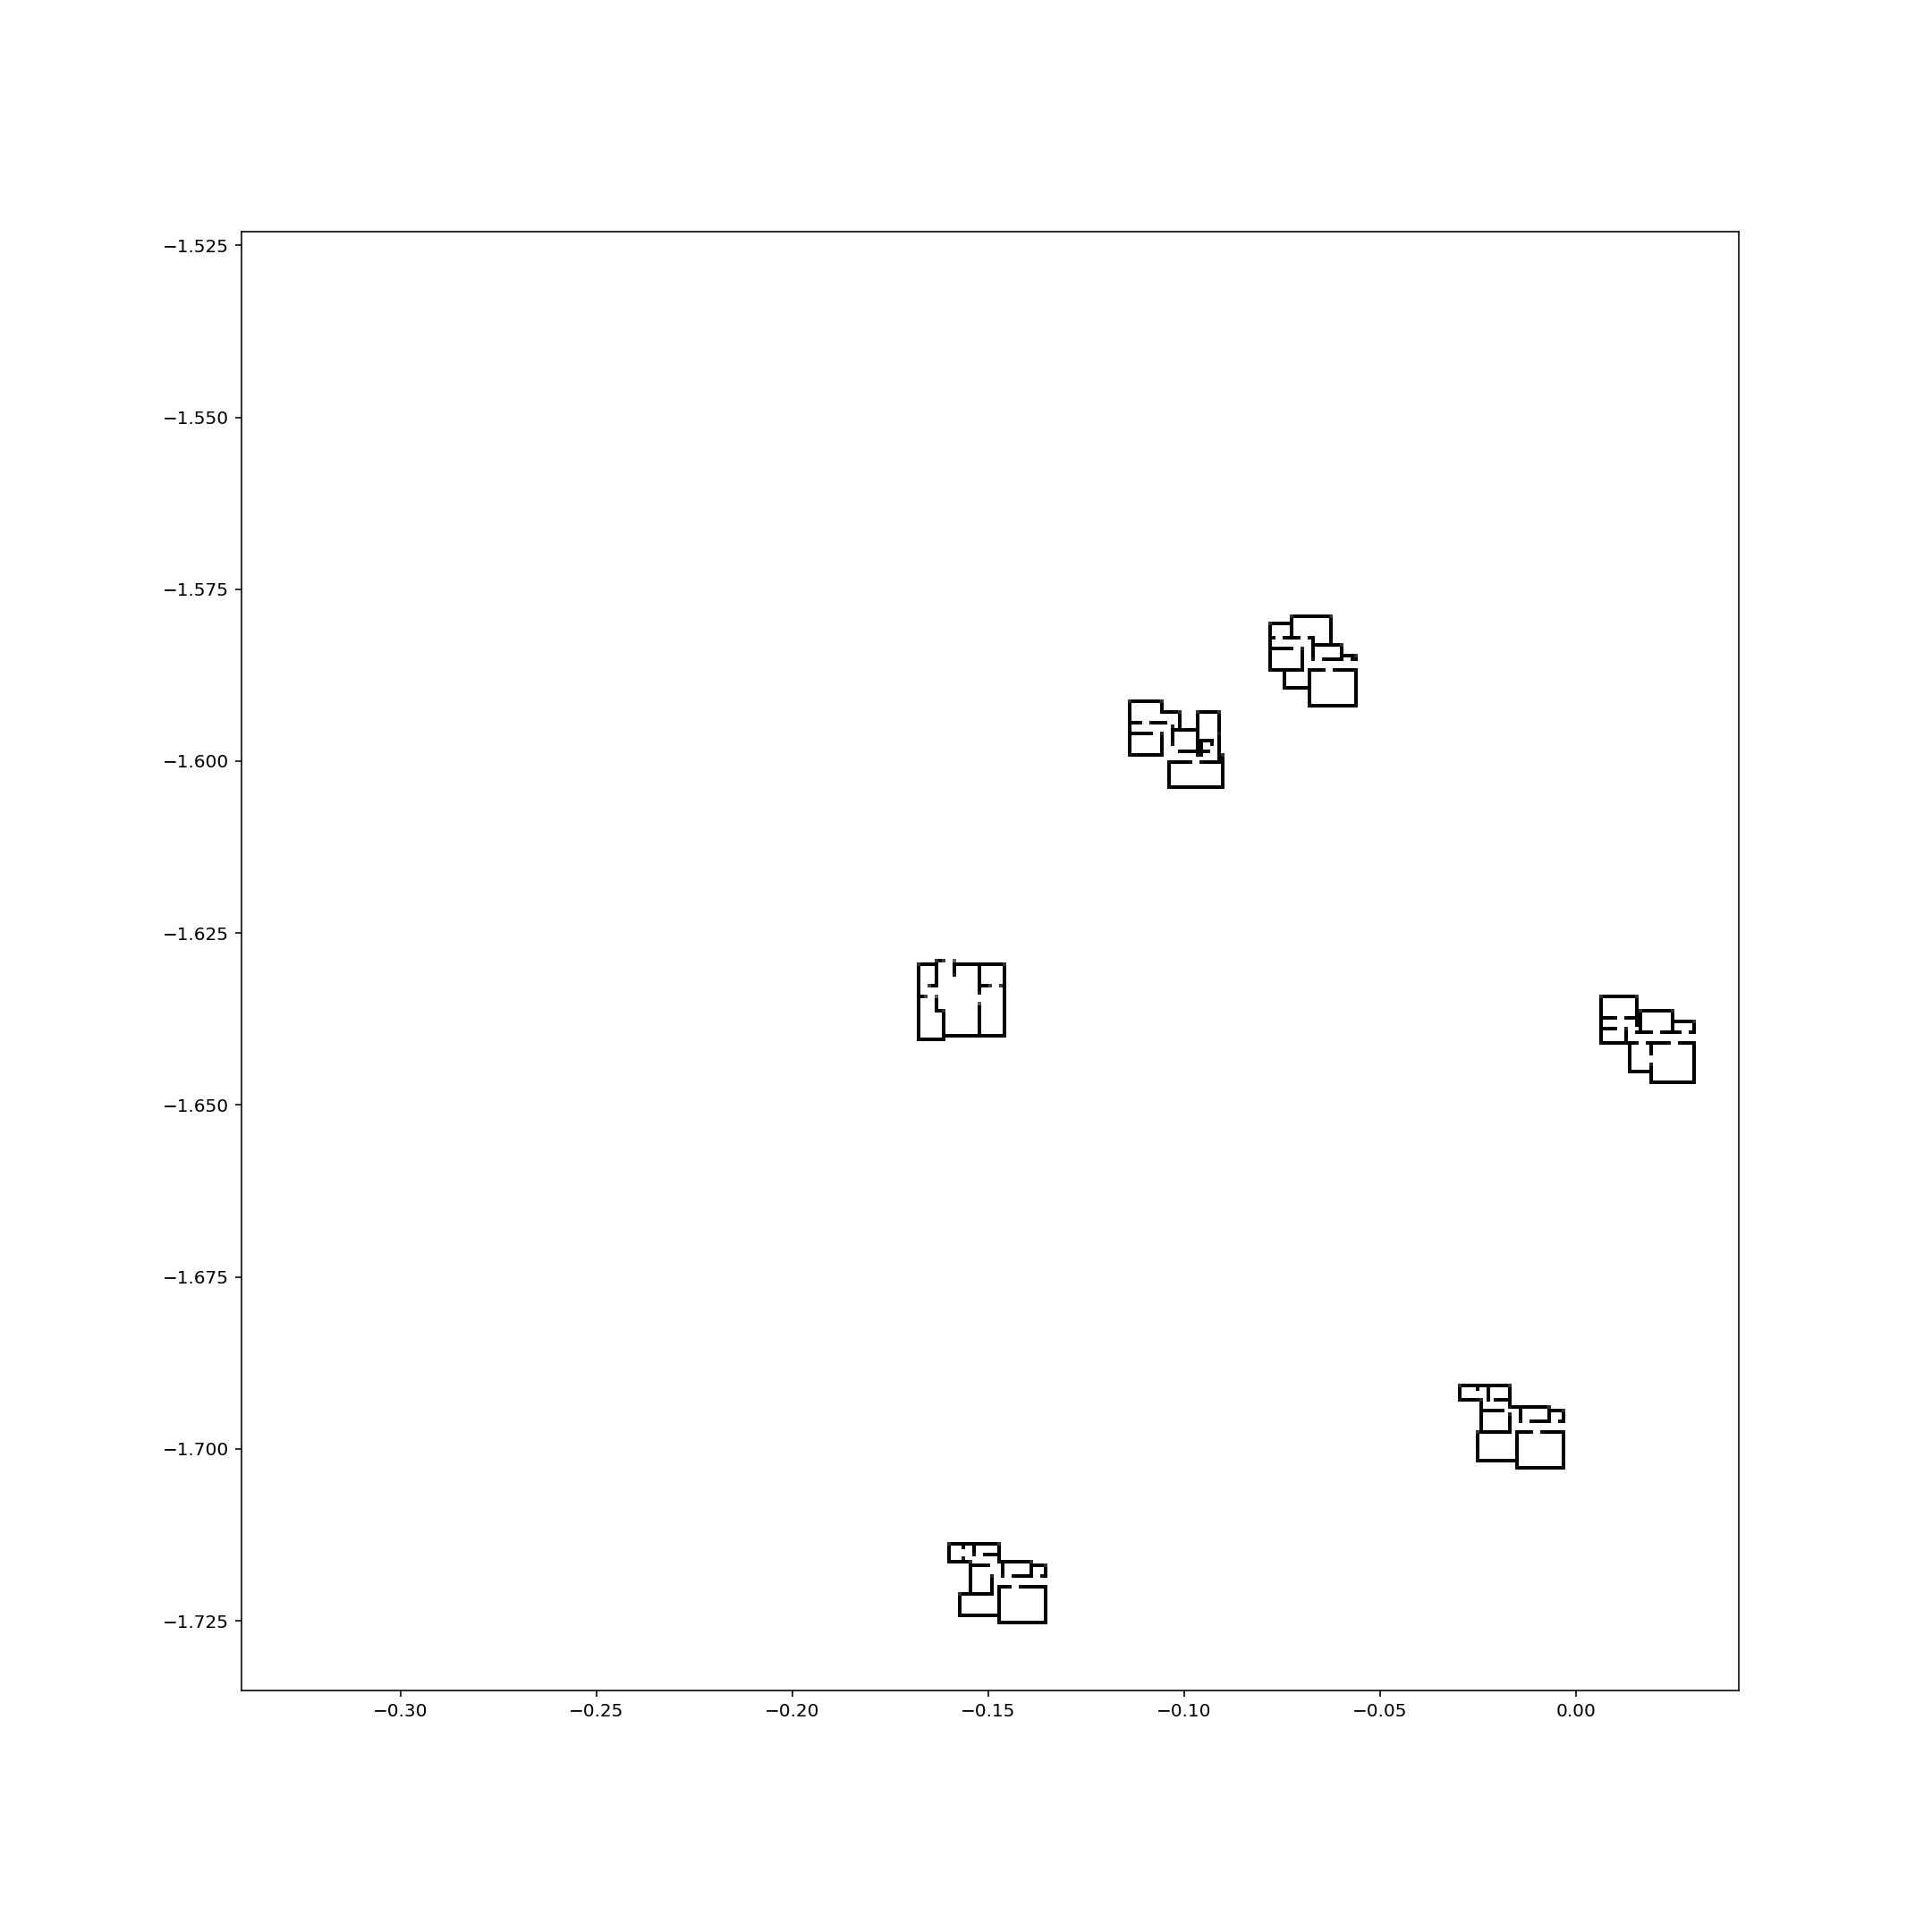

HTML(value='')

In [40]:
# interactive zoom into the latent space
%pylab notebook
plt.rcParams['figure.figsize'] = (15, 15)

main()

w = widgets.HTML()
display(w)